# Dataset Preparation for First ICU Prediction

## Imports & Inits

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import sys
sys.path.append('../')

import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
np.set_printoptions(precision=2)

from utils.metrics import BinaryAvgMetrics
from utils.plots import *

import pandas as pd
import pickle
from pathlib import Path

## 100 Run Performance Results

In [3]:
workdir = Path('./data/work_dir')

In [4]:
models = ['lr', 'rf']

bams = {}

for model in models:
  with open(workdir/model/'preds.pkl', 'rb') as f:
    targs = pickle.load(f)
    preds = pickle.load(f)
    probs = pickle.load(f)
    
  bams[model] = BinaryAvgMetrics(targs, preds, probs)

all_metrics = {}

for key in bams.keys():
  all_metrics[key] = []
  for i in range(len(bams[key].get_avg_metrics())):
    all_metrics[key].append(bams[key].get_avg_metrics().iloc[i]['Value'])

metrics = pd.DataFrame(all_metrics, index=['sensitivity', 'specificity', 'ppv', 'auroc', 'npv', 'f1'])
metrics

,lr,rf
sensitivity,0.894,0.822
specificity,0.620,0.732
ppv,0.422,0.487
auroc,0.843,0.857
npv,0.950,0.930
f1,0.573,0.612


In [5]:
model = 'lr'
bams[model].get_avg_metrics()

,Value,Definition
sensitivity,0.894,"When it's ACTUALLY YES, how often does it PREDICT YES?"
specificity,0.620,"When it's ACTUALLY NO, how often does it PREDICT NO?"
ppv,0.422,"When it PREDICTS YES, how often is it correct?"
auroc,0.843,Indicates how well the model is capable of distinguishing between classes
npv,0.950,"When it PREDICTS NO, how often is it correct?"
f1,0.573,Harmonic mean of sensitivity and ppv


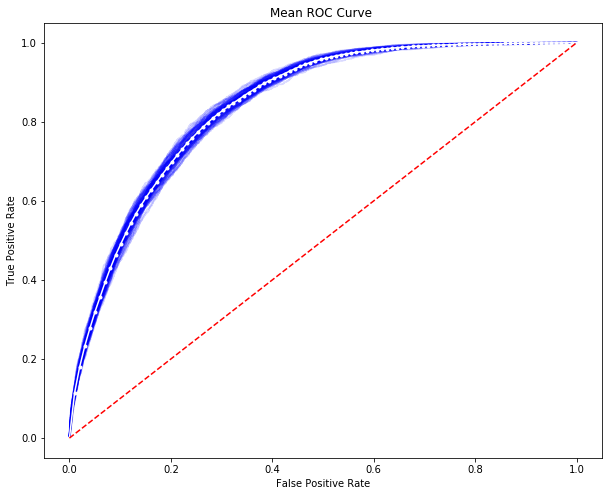

In [6]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
plot_mean_roc(ax, bams[model].targs, bams[model].probs)

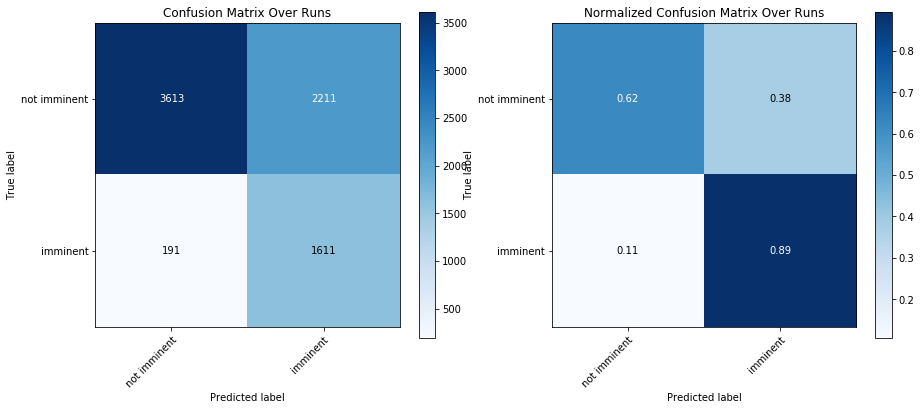

In [7]:
fig, ax = plt.subplots(1, 2, figsize=(15, 6))

plot_confusion_matrix(ax[0], bams[model].cm_avg, classes=['not imminent', 'imminent'], normalize=False,\
                      title='Confusion Matrix Over Runs')
plot_confusion_matrix(ax[1], bams[model].cm_avg, classes=['not imminent', 'imminent'], normalize=True,\
                      title='Normalized Confusion Matrix Over Runs')
plt.show()

## Temporal Performance Analysis

### Subsect data

In [8]:
path = Path('./data')
df = pd.read_csv(path/'processed_dataset.csv', parse_dates=['admittime', 'dischtime', 'intime', 'charttime'])

df['relative_charttime'] = (df['charttime'] - df['intime']).apply(lambda x: int(x.value/(1e9*60*60)))
df['relative_charttime'].describe()

count    50828.000000
mean    -285.889588  
std      288.572212  
min     -3388.000000 
25%     -361.000000  
50%     -207.000000  
75%     -123.000000  
max     -24.000000   
Name: relative_charttime, dtype: float64

In [9]:
# value in hours
e1 = -480
s1 = -120
e2 = -72
s2 = -24
step = 6

temporal_notes = []

for i in range(e1, s1, step):
  period = f'{i} ≤ t ≤ {i+step}'
  tmp = df.loc[((df['relative_charttime'] >= i) & (df['relative_charttime'] <= (i+step)))].copy()
  temporal_notes.append((period, tmp))

for i in range(e2, s2, step):
  period = f'{i} ≤ t ≤ {i+step}'
  tmp = df.loc[((df['relative_charttime'] >= i) & (df['relative_charttime'] <= (i+step)))].copy()
  temporal_notes.append((period, tmp))

In [10]:
df['relative_charttime'] = (df['charttime'] - df['intime']).apply(lambda x: int(x.value/(1e9*60*60)))
df['relative_charttime'].describe()

count    50828.000000
mean    -285.889588  
std      288.572212  
min     -3388.000000 
25%     -361.000000  
50%     -207.000000  
75%     -123.000000  
max     -24.000000   
Name: relative_charttime, dtype: float64

These lengths should not be different...

In [11]:
temporal_notes = []

for i in range(e1, s1, step):
  period = f'{i} ≤ t ≤ {i+step}'
  tmp = df.loc[((df['relative_charttime'] >= i) & (df['relative_charttime'] <= (i+step)))].copy()
  temporal_notes.append((period, tmp))

for i in range(e2, s2, step):
  period = f'{i} ≤ t ≤ {i+step}'
  tmp = df.loc[((df['relative_charttime'] >= i) & (df['relative_charttime'] <= (i+step)))].copy()
  temporal_notes.append((period, tmp))

In [12]:
s = 0
for (_, x) in temporal_notes:
  s += len(x)
tmp = df.loc[((df['relative_charttime'] >= e1) & (df['relative_charttime'] <= s1))\
               | ((df['relative_charttime'] >= e2) & (df['relative_charttime'] <= s2))].copy()
print(s - len(tmp))

6979


In [13]:
pickle.dump(temporal_notes, open(path/'temporal_notes.pkl', 'wb'))